In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#import

In [37]:
import glob, cv2, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.applications.resnet50 import ResNet50

#データフレーム作成

In [3]:
%%bash
# データを作業スペースに持ってくる
cp /content/drive/MyDrive/project/Kaggle_Dogs_vs_Cats_Redux/train_resize_128.zip /content/
cp /content/drive/MyDrive/project/Kaggle_Dogs_vs_Cats_Redux/test_resize_128.zip /content/


mkdir datasets
unzip /content/test_resize_128.zip -d "/content/datasets"
unzip /content/train_resize_128.zip -d "/content/datasets"

Output hidden; open in https://colab.research.google.com to view.

In [4]:
# trainのdf作成
path = sorted(glob.glob("/content/datasets/train_resize_128/*"))
label = [int('dog' in path[i]) for i in range(len(path))] # dog: 1, cat: 0

train = pd.DataFrame(path, columns=["path"])
train["label"] = label

print("train-dfのsize:", train.shape)

train.sample(5)

train-dfのsize: (25000, 2)


,path,label
12431,/content/datasets/train_resize_128/cat.9937.jpg,0
16582,/content/datasets/train_resize_128/dog.2421.jpg,1
7617,/content/datasets/train_resize_128/cat.5603.jpg,0
6795,/content/datasets/train_resize_128/cat.4864.jpg,0
24864,/content/datasets/train_resize_128/dog.9877.jpg,1


In [5]:
# train-validation分離
X = train["path"]
y = train["label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=500)

## train-df

In [6]:
# train-df作成
train = pd.DataFrame(X_train, columns=["path"])
train["label"] = y_train
train = train.sort_values('path')

print("train-dfのsize:", train.shape)

train.sample(3)

train-dfのsize: (20000, 2)


,path,label
53,/content/datasets/train_resize_128/cat.10044.jpg,0
19511,/content/datasets/train_resize_128/dog.5058.jpg,1
893,/content/datasets/train_resize_128/cat.10800.jpg,0


画像サイズ: (128, 128, 3)
画像ラベル: 0


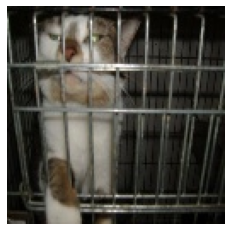

In [7]:
# train画像確認
i = np.random.randint(0, len(train))
img = cv2.imread(train["path"].iloc[i])

print("画像サイズ:", img.shape)
print("画像ラベル:", train["label"].iloc[i])

plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## validation-df

In [8]:
# val-df作成
val = pd.DataFrame(X_val, columns=["path"])
val["label"] = y_val
val = val.sort_values('path')

print("val-dfのsize:", val.shape)

val.sample(3)

val-dfのsize: (5000, 2)


,path,label
4164,/content/datasets/train_resize_128/cat.2496.jpg,0
8502,/content/datasets/train_resize_128/cat.640.jpg,0
2205,/content/datasets/train_resize_128/cat.11982.jpg,0


画像サイズ: (128, 128, 3)
画像ラベル: 0


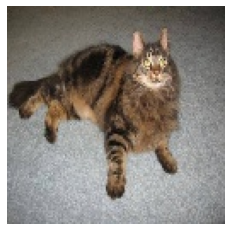

In [19]:
#val画像確認
i = np.random.randint(0, len(val))
img = cv2.imread(val["path"].iloc[i])

print("画像サイズ:", img.shape)
print("画像ラベル:", val["label"].iloc[i])

plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# batch-generator

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
画像ラベル: 0


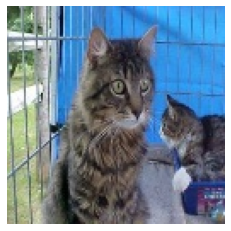

In [16]:
# batch生成
def batch_gen(df, batch_size):
    while True:
        batch = df.sample(batch_size)

        batch_x = []
        batch_y = []

        for index, items in batch.iterrows():
            filepath = items[0]
            label = items[1]

            img = cv2.imread(filepath)
            img = np.array(img).astype('float32')/255

            batch_x.append(img)
            batch_y.append(label)

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)

        yield (batch_x, batch_y)

# 動作確認
batch_size = 64

train_gen = batch_gen(train, batch_size) # この時点では関数は実行されない
x, y = next(train_gen)

i = np.random.randint(0, batch_size)
img = (x[i] * 255).astype('uint8')
print(type(x), type(y))
print("画像ラベル:", y[i])
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
画像ラベル: 1


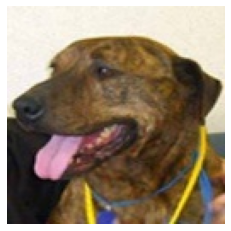

In [27]:
# validationのarray作成
val_x = []
val_y = []

for index, items in val.iterrows():
    filepath = items[0]
    label = items[1]

    img = cv2.imread(filepath)
    img = np.array(img).astype('float32')/255

    val_x.append(img)
    val_y.append(label)

val_x = np.array(val_x)
val_y = np.array(val_y)

# 確認
i = np.random.randint(0, len(val_y))
img = (val_x[i] * 255).astype('uint8')
print(type(val_x), type(val_y))
print("画像ラベル:", val_y[i])
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# モデル構築

In [12]:
img_size = cv2.imread(train["path"][0]).shape[0]

input = Input(shape=(img_size, img_size, 3))

RN = ResNet50(
        include_top = False,    # 全結合を層を含むか否か
        weights = 'imagenet',
        input_tensor = input
)

top_model = Sequential()
top_model.add(Flatten(input_shape = RN.output_shape[1:], name='top_start'))
top_model.add(Dense(1024, activation='relu'))
top_model.add(BatchNormalization())
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(64, activation='relu'))
top_model.add(Dense(1, activation='sigmoid'))

full_model = Model(
        inputs = RN.input,
        outputs = top_model(RN.output))

full_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
_____________________________

In [13]:
# ResNetは以下設定が相性良好
full_model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryCrossentropy(), tf.keras.metrics.BinaryAccuracy()])

# early_stopping: val_lossが5epocで改善しない場合はstop
ES = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5
)

# 学習

In [23]:
# 学習
steps = len(train) // batch_size

full_model.fit(
        train_gen,
        steps_per_epoch = steps,           # 1epoch内のstep数(312) = data_size(20000) / batch_size(64) 
        validation_data = (val_x, val_y),
        epochs = 20, 
        verbose = 1,
        callbacks = [ES]
)

Epoch 1/20
312/312 [==============================] - 49s 156ms/step - loss: 0.0304 - binary_crossentropy: 0.0304 - binary_accuracy: 0.9903 - val_loss: 0.1701 - val_binary_crossentropy: 0.1701 - val_binary_accuracy: 0.9412
Epoch 2/20
312/312 [==============================] - 46s 149ms/step - loss: 0.0208 - binary_crossentropy: 0.0208 - binary_accuracy: 0.9940 - val_loss: 0.0842 - val_binary_crossentropy: 0.0842 - val_binary_accuracy: 0.9726
Epoch 3/20
312/312 [==============================] - 47s 149ms/step - loss: 0.0116 - binary_crossentropy: 0.0116 - binary_accuracy: 0.9970 - val_loss: 0.0954 - val_binary_crossentropy: 0.0954 - val_binary_accuracy: 0.9708
Epoch 4/20
312/312 [==============================] - 46s 149ms/step - loss: 0.0083 - binary_crossentropy: 0.0083 - binary_accuracy: 0.9978 - val_loss: 0.0957 - val_binary_crossentropy: 0.0957 - val_binary_accuracy: 0.9724
Epoch 5/20
312/312 [==============================] - 47s 149ms/step - loss: 0.0049 - binary_crossentropy: 0

In [30]:
from sklearn.metrics import log_loss

pred = full_model.predict(val_x)
pred = pred.reshape(1, -1).tolist()[0]

print('log-loss:', log_loss(val_y.reshape(1, -1).tolist()[0], pred))

log-loss: 0.10221059326811027


In [38]:
# モデル保存
full_model.save("base-line_model.h5")
print(os.path.getsize('base-line_model.h5') * (10**-9), "GB")

!cp /content/base-line_model.h5 /content/drive/MyDrive/project/Kaggle_Dogs_vs_Cats_Redux/traned_model

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


0.46015919200000005 GB
